<a href="https://colab.research.google.com/github/Shujaat123/Noisy-AE-LSE/blob/main/ImageDenoising_UNET_PlusPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras.backend as K
import cv2
# import komm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Model
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

## Load useful packages
!pip install wget
# !pip install komm
from random import sample

import keras
# import os.path
from os import path
import h5py
# import keras.backend as K
import numpy as np
# import tensorflow as tf
import wget
# import cv2
# import komm
# from keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint
from keras.layers import *
# from keras.models import Model
# from keras.models import load_model
from keras.utils.np_utils import to_categorical
# from sklearn.metrics import accuracy_score, balanced_accuracy_score
# from sklearn.metrics import confusion_matrix
# from tensorflow.keras.optimizers import Adam
# from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import gc

In [2]:
classes = ('cloudy','rain','shine','sunrise')
data_path = 'https://raw.githubusercontent.com/Shujaat123/Weather_Classification/master/dataset/'

flist = []
for fname in classes:
  filename = 'WeatherClassificationDB_'+fname+'.mat'
  if(path.exists(filename)):
    !rm $filename
    print('existing file:', filename, ' has been deleted')
  print('downloading latest version of file:', filename)
  file_path = data_path + filename
  wget.download(file_path, filename)
  print('DONE')
  flist.append(filename)

existing file: WeatherClassificationDB_cloudy.mat  has been deleted
downloading latest version of file: WeatherClassificationDB_cloudy.mat
DONE
existing file: WeatherClassificationDB_rain.mat  has been deleted
downloading latest version of file: WeatherClassificationDB_rain.mat
DONE
existing file: WeatherClassificationDB_shine.mat  has been deleted
downloading latest version of file: WeatherClassificationDB_shine.mat
DONE
existing file: WeatherClassificationDB_sunrise.mat  has been deleted
downloading latest version of file: WeatherClassificationDB_sunrise.mat
DONE


In [3]:
cloudy_imgs = h5py.File(flist[0], 'r')['images']['input']
cloudy_labels = h5py.File(flist[0], 'r')['images']['label']

rain_imgs = h5py.File(flist[1], 'r')['images']['input']
rain_labels = h5py.File(flist[1], 'r')['images']['label']

shine_imgs = h5py.File(flist[2], 'r')['images']['input']
shine_labels = h5py.File(flist[2], 'r')['images']['label']

sunrise_imgs = h5py.File(flist[3], 'r')['images']['input']
sunrise_labels = h5py.File(flist[3], 'r')['images']['label']


In [4]:
print(cloudy_imgs.shape) # (NHWC)
print(cloudy_labels.shape)

print(rain_imgs.shape) # (NHWC)
print(rain_labels.shape)

print(shine_imgs.shape) # (NHWC)
print(shine_labels.shape)

print(sunrise_imgs.shape) # (NHWC)
print(sunrise_labels.shape)


InputImages = np.concatenate((cloudy_imgs,rain_imgs,shine_imgs,sunrise_imgs), axis = 0)
InputImages = InputImages/InputImages.max()
ClassLabels = np.concatenate((cloudy_labels,rain_labels,shine_labels,sunrise_labels), axis = 0)

InputImages.shape
ClassLabels.shape
ClassLabels = to_categorical(np.squeeze(ClassLabels)-1)
ClassLabels.shape

(207, 256, 256, 3)
(207, 1, 1, 1)
(215, 256, 256, 3)
(215, 1, 1, 1)
(253, 256, 256, 3)
(253, 1, 1, 1)
(357, 256, 256, 3)
(357, 1, 1, 1)


(1032, 4)

In [5]:
cloudy_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==0)).flatten())
rain_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==1)).flatten())
shine_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==2)).flatten())
sunrise_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==3)).flatten())
total_list = cloudy_list + rain_list + shine_list + sunrise_list

print('Number of \'cloudy\' samples:',len(cloudy_list))
print('Number of \'rain\' samples:',len(rain_list))
print('Number of \'shine\' samples:',len(shine_list))
print('Number of \'sunrise\' samples:',len(sunrise_list))
print('Total number of samples:',len(total_list))

Number of 'cloudy' samples: 207
Number of 'rain' samples: 215
Number of 'shine' samples: 253
Number of 'sunrise' samples: 357
Total number of samples: 1032


In [6]:
cloudy_train = sample(cloudy_list, 150)
rain_train = sample(rain_list, 150)
shine_train = sample(shine_list, 150)
sunrise_train = sample(sunrise_list, 150)
train_list = cloudy_train + rain_train + shine_train + sunrise_train

Input_train = InputImages[train_list]
Label_train = ClassLabels[train_list]

# valid select 20 cloudy, 20 rain, 20 shine and 20 sunrise samples
cloudy_val = sample(set(cloudy_list) - set(cloudy_train), 20)
rain_val = sample(set(rain_list) - set(rain_train), 20)
shine_val = sample(set(shine_list) - set(shine_train), 20)
sunrise_val = sample(set(sunrise_list) - set(sunrise_train), 20)
val_list = cloudy_val + rain_val + shine_val + sunrise_val

Input_val = InputImages[val_list]
Label_val = ClassLabels[val_list]

## test
test_list = list(set(total_list) - set(train_list) - set(val_list))

# test_list
Input_test = InputImages[test_list]
Label_test = ClassLabels[test_list]

In [7]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
print(Input_train.shape)
noise_factor = 0.1
temp = np.empty((1,64,64,3))
# temp2 = np.empty((1,64,64,3))
for i in range(0, Input_train.shape[0]):
  patches = image.extract_patches_2d(Input_train[i], (64, 64), random_state=40, max_patches=16)
  # noisy = patches + 0.175 * np.random.normal(0, 1, size= patches.shape)
  temp = np.concatenate((temp,patches), axis = 0)
  # temp2 = np.concatenate((temp2,noisy), axis = 0)
y_train = np.asarray(temp[1:])

x_train = y_train + noise_factor * np.random.normal(0, 1, size= y_train.shape)
x_train = x_train/np.max(np.abs(x_train))
x_train = np.clip(x_train, 0., 1.)
print(x_train.shape, y_train.shape)


y_val = Input_val
x_val = y_val + noise_factor * np.random.normal(0, 1, size= y_val.shape)
x_val = x_val/np.max(np.abs(x_val))
x_val = np.clip(x_val, 0., 1.)

print(y_val.shape, x_val.shape)

y_test = Input_test
x_test = y_test + noise_factor * np.random.normal(0, 1, size= y_test.shape)
x_test = x_test/np.max(np.abs(x_test))
x_test = np.clip(x_test, 0., 1.)
print(y_test.shape, y_test.shape)
# temp = np.empty((1,64,64,3))
# for i in range(0, Input_val.shape[0]):
#   patches = image.extract_patches_2d(Input_val[i], (64, 64), random_state=40, max_patches=16)
#   temp = np.concatenate((temp,patches), axis = 0)
# Input_val = np.asarray(temp[1:])
# print(Input_val.shape)
# gc.collect()

(600, 256, 256, 3)
(9600, 64, 64, 3) (9600, 64, 64, 3)
(80, 256, 256, 3) (80, 256, 256, 3)
(352, 256, 256, 3) (352, 256, 256, 3)


In [8]:
def conv_block(in_conv, num_filter = 32, kernel_size = 3):
  x = Conv2D(num_filter, kernel_size, padding='same')(in_conv)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = Conv2D(num_filter, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  y = Activation(activation='relu')(x)
  up = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(in_conv)
  down = MaxPooling2D(pool_size=(2,2))(y)
  return down, y, up

def dec_merge_block(encoder_output, SC, num_filter = 256, kernel_size = 3):
  x = Concatenate()([encoder_output, SC])
  yd, y, yu = enc_conv_block(x, num_filter, kernel_size)
  return yd, y, yu

def my_model():
  num_filter = 32
  kernel_size = 3
  
  input_img = Input(shape = (None, None, 3), name = 'input_img')
  x00d, x00, x00u = conv_block(input_img, num_filter, kernel_size) # X00
  x10d, x10, x10u = conv_block(x00d, num_filter, kernel_size) # X10
  x20d, x20, x20u = conv_block(x10d, num_filter, kernel_size) # X20
  x30d, x30, x30u = conv_block(x20d, num_filter, kernel_size) # X30
  x40d, x40, x40u = conv_block(x30d, num_filter, kernel_size) # X40

  x01d, x01, x01u = conv_block(Concatenate()([x00, x10u]), num_filter, kernel_size) # X01
  x11d, x11, x11u = conv_block(Concatenate()([x10, x20u]), num_filter, kernel_size) # X11
  x21d, x21, x21u = conv_block(Concatenate()([x20, x30u]), num_filter, kernel_size) # X21
  x31d, x31, x31u = conv_block(Concatenate()([x30, x40u]), num_filter, kernel_size) # X31
  
  x02d, x02, x02u = conv_block(Concatenate()([x00, x01, x11u]), num_filter, kernel_size) # X02
  x12d, x12, x12u = conv_block(Concatenate()([x10, x11, x21u]), num_filter, kernel_size) # X12
  x22d, x22, x22u = conv_block(Concatenate()([x20, x21, x31u]), num_filter, kernel_size) # X22

  x03d, x03, x03u = conv_block(Concatenate()([x00, x01, x02, x12u]), num_filter, kernel_size) # X03
  x13d, x13, x13u = conv_block(Concatenate()([x10, x11, x12, x22u]), num_filter, kernel_size) # X13

  x04d, x04, x04u = conv_block(Concatenate()([x00, x01, x02, x03, x13u]), num_filter, kernel_size) # X04

  x = Conv2D(3, (1,1), padding= 'same', name='1by1conv')(x04)
  output = Add(name='output')([x, input_img])

  model = Model(inputs=[input_img], outputs=[output])
  model.compile(optimizer=Adam(learning_rate = 1e-4), 
                loss={ 'output': 'mean_squared_error'})

  return model

model = my_model()
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  
checkpoint = ModelCheckpoint('models\\model-best.h5',
                                  verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

model = my_model()
history = model.fit(x_train, y_train,
                        validation_data = (x_val, y_val),
                        epochs=100, batch_size=16, callbacks=[checkpoint, es], verbose=1)

del model
from tensorflow import keras
model = keras.models.load_model('models\\model-best.h5')

Epoch 1/100
600/600 [==============================] - 117s 164ms/step - loss: 0.0361 - val_loss: 0.0057

Epoch 00001: val_loss improved from inf to 0.00571, saving model to models\model-best.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
600/600 [==============================] - 80s 133ms/step - loss: 0.0060 - val_loss: 0.0045

Epoch 00002: val_loss improved from 0.00571 to 0.00447, saving model to models\model-best.h5
Epoch 3/100
600/600 [==============================] - 82s 137ms/step - loss: 0.0049 - val_loss: 0.0039

Epoch 00003: val_loss improved from 0.00447 to 0.00388, saving model to models\model-best.h5
Epoch 4/100
600/600 [==============================] - 82s 137ms/step - loss: 0.0041 - val_loss: 0.0031

Epoch 00004: val_loss improved from 0.00388 to 0.00313, saving model to models\model-best.h5
Epoch 5/100
600/600 [==============================] - 80s 134ms/step - loss: 0.0035 - val_loss: 0.0026

Epoch 00005: val_loss improved from 0.00313 to 0.00257, saving model to models\model-best.h5
Epoch 6/100
600/600 [==============================] - 80s 133ms/step - loss: 0.0030 - val_loss: 0.0021

Epoch 00006: val_loss improved from 0.00257 to 0.00209, saving model to models\model-best.h5
Epoch 7/10

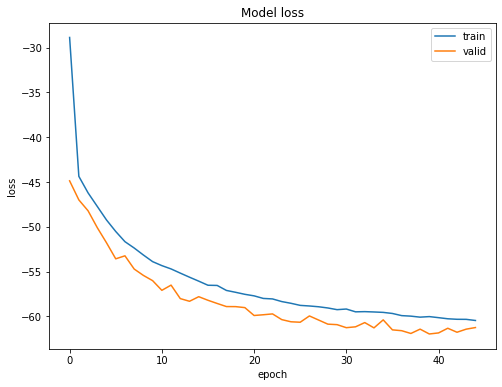

In [10]:
plt.figure(1, figsize = (8,6))
plt.plot((20*np.log10(history.history['loss'])))
plt.plot((20*np.log10(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [11]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(9600, 64, 64, 3) (9600, 64, 64, 3)
(80, 256, 256, 3) (80, 256, 256, 3)
(352, 256, 256, 3) (352, 256, 256, 3)


In [12]:
# model = keras.models.load_model('models\\model-best.h5')
# test_pred = model.predict(x_test, batch_size=1)

In [13]:
from tensorflow.image import psnr

def Calculate_Noise_vs_Stats(x_test,norm_test,model):
  
  test_pred = model.predict(x_test, batch_size=1)
  test_pred = np.clip(test_pred, 0., 1.)

  psnr_test_input = psnr(x_test, y_test, max_val=1.0)

  psnr_pred_output_test = psnr(test_pred, y_test, max_val=1.0)
  # psnr_normal_input = psnr(x_test_noisy_normal, x_test, max_val=1.0)

  print('Test Set: ', np.mean(psnr_test_input), np.mean(psnr_pred_output_test))

  return np.mean(psnr_test_input), np.mean(psnr_pred_output_test)

In [14]:
PSNR_results = Calculate_Noise_vs_Stats(x_test, y_test, model)

Test Set:  15.022941 31.633972


In [15]:
test_pred = model.predict(x_test, batch_size=1)
test_pred = np.clip(test_pred, 0., 1.)
# test_pred = test_pred/np.max(test_pred)

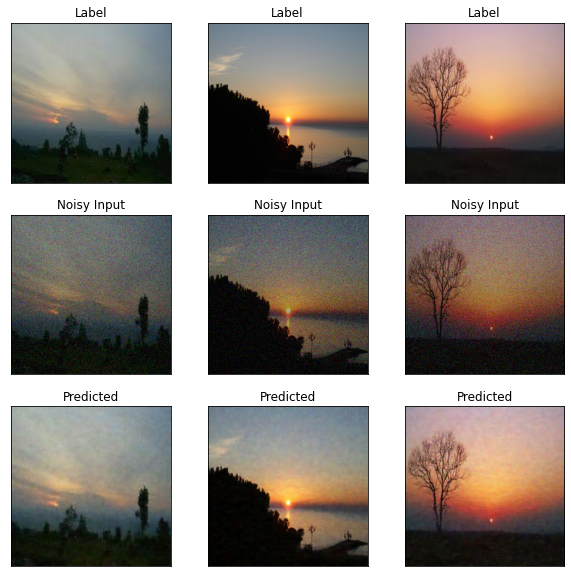

In [16]:
n = 3
plt.figure(figsize=(10, 10))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(np.squeeze((y_test[i]*255).astype('uint8')))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("Noisy Input")
    plt.imshow(np.squeeze((x_test[i]*255).astype('uint8')))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Predicted")
    plt.imshow(np.squeeze((test_pred[i]*255).astype('uint8')))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

In [17]:
print(np.max(y_test), np.min(y_test))
print(np.max(x_test), np.min(x_test))
print(np.max(test_pred), np.min(test_pred))

1.0 0.0
1.0 0.0
1.0 0.0


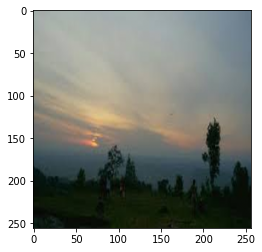

In [18]:
plt.imshow(np.squeeze(y_test[0]))

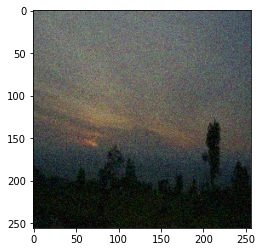

In [19]:
plt.imshow(np.squeeze(x_test[0]))

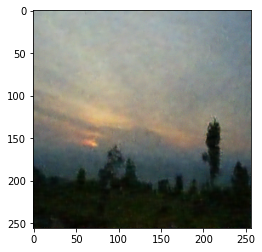

In [20]:
plt.imshow(np.squeeze(test_pred[0]))